In [25]:
import os
import json
import yaml
import torch
import random
import detectron2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import wandb
import tensorboard

from train import get_dataset_dicts, get_dataset_dicts_with_regions, random_visu, setup_cfg, MyTrainer, load_json_arr, find_best_model

import shutil


In [2]:
# Check tb to avoid error during training
tensorboard.__version__

'1.15.0'

In [3]:
# Verify GPU information
print (torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0)
       , torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using CUDA
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True 1 0 <torch.cuda.device object at 0x1555500987f0> NVIDIA A30
Using device: cuda

NVIDIA A30
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [26]:
### Set up ###

## Name annotations.json file in train and val ##
annotation_json = "via_region_data_train_25_empty_annotations.json"
experiment_name = "lr001_BS4_empty-annot-25_test-3"
conf_name = "NSOD2cfg_1000_169r_1000pix_noBT_" + experiment_name
conf_file = conf_name + ".yaml"

# Create a new output directory for output and metrics, if it doesn't exist
out_dir = "../NSO/output/" + experiment_name
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print ("The new out_dir directory is created!")


## D2 Configuration Args ##
base_model_ = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
trains_ = ("train",)
tests_ = ("val",)
workers_ = 2
base_lr_ = 0.001
eval_period_ = 1000
warm_iter_ = 200
ims_per_batch_ = 4
max_iter_ = 90000
out_dir_ = out_dir
filter_empty_annot_ = False

## Patience for early stopping ##
num_patience = 5

## Evaluation
# If test set is val:
val_coco_json = "val_coco_format.json"


In [27]:

### Indicate to D2 how to read dataset if not in coco format: ###

# D2 metadata: name of classes and colors of annotations
classes = ["asset"]
colors = [(249, 180, 45)]

# Register dataset and metadata
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d:
                            get_dataset_dicts(os.path.join("../NSO", d), annotation_json))
    # Key-value mapping to interpret what’s in the dataset: names of classes, colors of classes
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors

AssertionError: Dataset 'train' is already registered!

In [7]:
### Visualise annotations & images of trainning dataset ###

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../NSO/train", annotation_json)    
random_visu(dataset_dicts, metadata, 1)

KeyboardInterrupt: 

In [6]:
### Make D2 configuration  ###

cfg = setup_cfg(base_model=base_model_, trains=trains_, tests=tests_, workers=workers_, base_lr=base_lr_, eval_period=eval_period_, warm_iter=warm_iter_,
                ims_per_batch=ims_per_batch_, max_iter=max_iter_, out_dir=out_dir_, filter_empty_annot=filter_empty_annot_)
# update_model arg can be used to load already trained model
#cfg.INPUT.MIN_SIZE_TRAIN = 1000

# Save your configurations
with open(os.path.join(out_dir, conf_file), "w") as file:
    yaml.dump(cfg, file)
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: false
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - val
  TRAIN:
  - train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: 1000
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    

In [8]:
### Set up logging with Wandb ###

## If cfg is not defined, load it from yaml file: ##
#config = load_yaml(os.path.join(out_dir, conf_file))
#wandb.login()

# COMMENT OUT: AttributeError: module 'cgi' has no attribute 'escape': requirements tensorboard>=2.4.0 #167
#%load_ext tensorboard
#%tensorboard --logdir output

# Give the same name as output subfolder and confname - no need for wandb.login() at beginning if wand.init() is used
os.environ["WANDB_NOTEBOOK_NAME"] = "config_train_evaluate"
wandb.init(
    project='P1',
    sync_tensorboard=True,
    save_code=True,
    config=cfg,
    name=experiment_name,
    notes=annotation_json,
    settings=wandb.Settings(
        start_method="thread",
        console="off"
    )
)

# Never worked:
#%env "WANDB_NOTEBOOK_NAME" "config_train_evaluate"

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find config_train_evaluate.
wandb: Currently logged in as: joel-deplaen (critical_infra_detection). Use `wandb login --relogin` to force relogin


In [ ]:
### Training with eval ###

## Train ##
trainer = MyTrainer(cfg, patience = num_patience) 
trainer.resume_or_load(resume=False)
trainer.train()
print ("Training finished. \n")

[08/16 18:03:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[08/16 18:03:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomBrightness(intensity_min=0.8, intensity_max=1.8), RandomContrast(intensity_min=0.6, intensity_max=1.3), RandomSaturation(intensity_min=0.8, intensity_max=1.4), RandomLighting(scale=0.7)]
[08/16 18:15:44 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   asset    | 638          |
|            |              |
[08/16 18:15:44 d2.data.build]: Using training sampler TrainingSampler
[08/16 18:15:44 d2.data.common]: Serializing 19803 elements to byte tensors and concatenating them all ...
[08/16 18:15:44 d2.data.common]: Serialized dataset takes 3.54 MiB


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in ../NSO/output/lr001_BS4_empty-annot-25_test-3


[08/16 18:15:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(1000, 1000), max_size=1333, sample_style='choice'), RandomFlip()]


epoch is MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES

total_loss: This is a weighted sum of the following individual losses calculated during the iteration. By default, the weights are all one.

loss_cls: Classification loss in the ROI head. Measures the loss for box classification, i.e., how good the model is at labelling a predicted box with the correct class.

loss_box_reg: Localisation loss in the ROI head. Measures the loss for box localisation (predicted location vs true location).

loss_rpn_cls: Classification loss in the Region Proposal Network. Measures the "objectness" loss, i.e., how good the RPN is at labelling the anchor boxes as foreground or background.

loss_rpn_loc: Localisation loss in the Region Proposal Network. Measures the loss for localisation of the predicted regions in the RPN.

loss_mask: Mask loss in the Mask head. Measures how "correct" the predicted binary masks are.

For more details on the losses (1) and (2), take a look at the Fast R-CNN paper and the code.

For more details on the losses (3) and (4), take a look at the Faster R-CNN paper and the code.

For more details on the loss (5), take a look at the Mask R-CNN paper and the code.

In [28]:
### Make figure directory ###

# Create a new directory to place figures
fig_dir = "../fig"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print ("The figure directory is created!")

# Directory for figures of each configuration
experiment_fig_dir = os.path.join(fig_dir, conf_name) 
if not os.path.exists(experiment_fig_dir):
    os.makedirs(experiment_fig_dir)
    print ("The figure plot directory is created!")

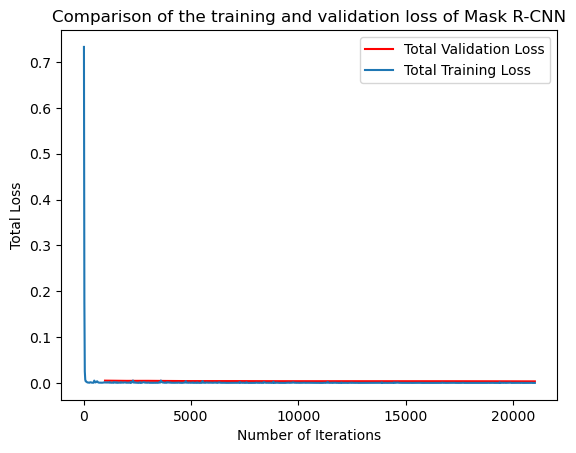

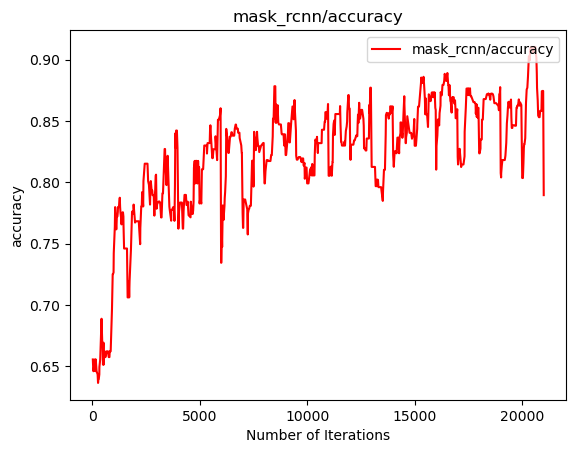

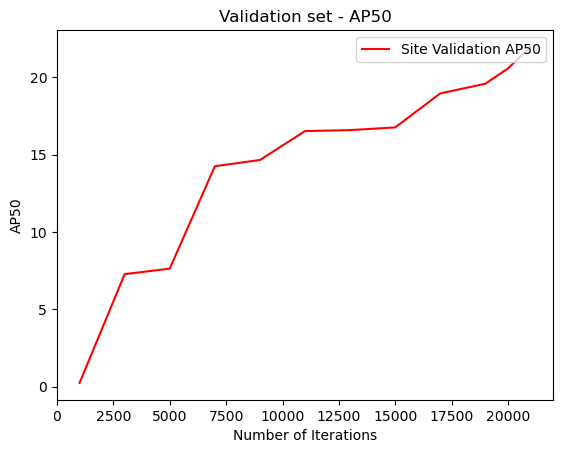

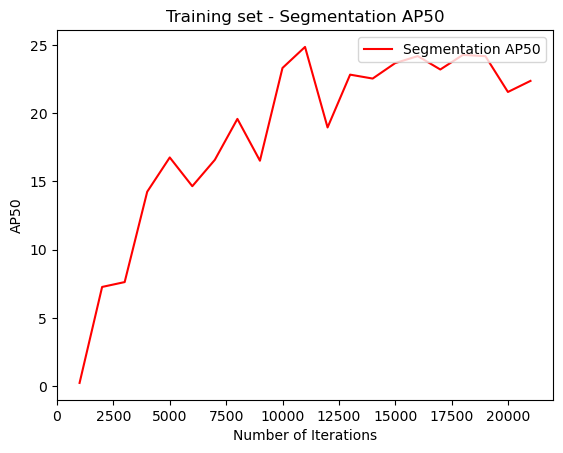

In [5]:
### Plot training and validation loss, accuracy, AP50 - train/val ###

# Load json with metrics
experiment_folder = out_dir
experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# Loss plot
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], label='Total Validation Loss', color='red')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], label='Total Training Loss')
plt.legend(loc='upper right')
plt.title('Comparison of the training and validation loss of Mask R-CNN')
plt.ylabel('Total Loss')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir + '/loss.png')
plt.show()

# Accuracy
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], 
    [x['mask_rcnn/accuracy'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], label='mask_rcnn/accuracy', color='red')
plt.legend(loc='upper right')
plt.title('mask_rcnn/accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir +'/acuracy.png')
plt.show()

# AP50 - val ###
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_ap' in x], 
    [x['validation_ap'] for x in experiment_metrics if 'validation_ap' in x], label='Site Validation AP50', color='red')
plt.legend(loc='upper right')
plt.title('Validation set - AP50')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir+'/AP50_val.png')
plt.show()

# AP50 - train
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'segm/AP50' in x], 
    [x['segm/AP50'] for x in experiment_metrics if 'segm/AP50' in x], label='Segmentation AP50', color='red')
plt.legend(loc='upper right')
plt.title('Training set - Segmentation AP50')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir +'/AP50_train.png')
plt.show()


In [29]:
### IF the config were NOT previously registered, run those cells ###

cfg = get_cfg()
cfg.OUTPUT_DIR = out_dir
config_path = os.path.join(out_dir, conf_file)
cfg.INPUT.MIN_SIZE_TRAIN = 1000
cfg.RESIZE= False

In [30]:
### If val not registered previsously, register it ###

#Metedata
classes = ["asset"]
colors = [(249, 180, 45)]

# Register dataset and metadata
for d in [ "val"]:
    DatasetCatalog.register(d, lambda d=d:
                            get_dataset_dicts(os.path.join("../NSO", d), annotation_json))
    # Key-value mapping to interpret what’s in the dataset: names of classes, colors of classes
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors 

AssertionError: Dataset 'val' is already registered!

In [ ]:
# A) get_dataset_dicts ALL images of validation
dataset_dicts = get_dataset_dicts("../NSO/val", annotation_json)
metadata = MetadataCatalog.get("val")

In [6]:
# B: get_dataset_dicts only for images with validation: If there are a lot of empty annotations
dataset_dicts = get_dataset_dicts_with_regions("../NSO/val", annotation_json)
metadata = MetadataCatalog.get("val")

In [31]:
### Find the best model in the output directory ###

best_model_path = find_best_model(out_dir, ".pth")

if best_model_path:
    best_model = best_model_path.split('/')[-1]
    print(f"Highest numbered file with extension .pth: is {best_model} at {best_model_path}")
else:
    print(f"No file with extension .pth found in the directory.")



Highest numbered file with extension .pth: is model_11.pth at ../NSO/output/lr001_BS4_empty-annot-25_test-3/model_11.pth


In [32]:
### Set config from training and select param for eval ###

# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.merge_from_file(os.path.join(out_dir, conf_file))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, best_model)# path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.DATASETS.TEST = ("val", )

predictor = DefaultPredictor(cfg)

#Try me: https://github.com/facebookresearch/detectron2/issues/1059
#trainer = MyTrainer(cfg)
#trainer.resume_or_load(resume=True)


Loading config ../NSO/output/lr001_BS4_empty-annot-25_test-3/NSOD2cfg_1000_169r_1000pix_noBT_lr001_BS4_empty-annot-25_test-3.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
### TEST Visualise inference ###
from visualisation_prediction import random_visu_prediction

random_visu_prediction(dataset_dicts, metadata, predictor, experiment_fig_dir, 20)

In [ ]:
### OLD -  CHECK WHY NEW FUNCION (random_visu_prediction) PRODUCES WARNING AND THIS ONE NOT: Visualise inference ###

# # Visu
# for d in random.sample(dataset_dicts, 5):    
#     im = cv.imread(d["file_name"])
#     outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#     v = Visualizer(im[:, :, ::-1],
#                    metadata=metadata,  
#                    instance_mode=ColorMode.IMAGE
#     )
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     #plt.imshow(out.get_image()[:, :, ::-1])
#     plt.figure(figsize=(20, 20))
#     plt.imshow(out.get_image()[:, :, :])
#     plt.show()
#     #save im + annots
#     cv.imwrite(os.path.join(experiment_fig_dir, "visu_inference" + d["file_name"].split("/")[-1]), out.get_image()[:, :, ::-1])
    

In [48]:
### Copy "val_coco_format.json" to out_dir ###

#GOAL: TO AVOID ISSUE FINDING val_coco_format.json WHILE EVALUATING

# Specify the paths to the source file and the destination folder
source_file = os.path.join(out_dir,"eval",val_coco_json)
destination_folder = os.path.join(out_dir)

# Construct the destination path by joining the destination folder and the source file's base name
destination_path = os.path.join(destination_folder, os.path.basename(source_file))

# Copy the file to the destination folder
shutil.copy(source_file, destination_path)

print(f"File copied to: {destination_path}")

File copied to: ../NSO/output/lr001_BS4_empty-annot-25_test-3/val_coco_format.json


In [51]:
### Evaluate performance metrics with COCO API ###
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#Construct the absolute path to the COCO JSON annotation file in eval folder

# Initialize the COCOEvaluator
evaluator = COCOEvaluator("val", output_dir=out_dir)
# Load the validation dataset
val_loader = build_detection_test_loader(cfg, "val")
# Perform inference and evaluation
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(results)


/scistor/ivm/jpl204/miniconda3/envs/nso_fix/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [ ]:
### No evaluation single GPU training ###

# Setting up model configugation for training
# initializes an empty config
cfg = get_cfg()

# add custom component to configuration
# load values from API: https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
#https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.DATASETS.TEST = () # should not be set for training: https://github.com/facebookresearch/detectron2/issues/951
# initiate weights from model zoo
# check points (.pth) = model's parameters and optimizer state to resume training or evalate performance
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
# set learning rate
cfg.SOLVER.BASE_LR = 0.001
# Dataloader provides data to the model
# Load data to GPU: the more data you put into the GPU memory, the less memory is available for the model (4 in Spacenet)
# https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/33?page=2
# https://stackoverflow.com/questions/53998282/how-does-the-number-of-workers-parameter-in-pytorch-dataloader-actually-work
cfg.DATALOADER.NUM_WORKERS = 2
# real batch size:  number of training examples utilized in one iteration.
cfg.SOLVER.IMS_PER_BATCH = 4
# parameter  used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training
# "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512). Spacenet uses 16 for 4 GPUs 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# Number of class = 1 (1 asset Type)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# config not included SPACENET
# adjust up if val mAP is still rising, adjust down if overfit/ 300 iterations seems good for toy dataset
#cfg.SOLVER.MAX_ITER = 100    
# [] => do not decay learning rate
#configuration specifies the iteration steps at which the learning rate is decreased during training.
#cfg.SOLVER.STEPS = []
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.GAMMA = 0.05
#number of itteration after wich the validation set is used for evaluation
#cfg.TEST.EVAL_PERIOD = 50 


# Directory for (logs, configs, metrics, and model checkpoints)
cfg.OUTPUT_DIR = "../NSO/output"
# print configs 
print(cfg.dump())

# Save your configurations for multi-GPU use
with open("../NSO/NSOD2cfg_1000_169r_1000pix_noBT_001LR_4BS_128BSPI.yaml", "w") as file:
    yaml.dump(cfg, file)
    
    
### Single GPU Training ###

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


# DefaultTrainer" which contains pre-defined default logic for standard training workflow.
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#Expect skip loading parameter because: The warning message is expected. Because your dataset has different number of classes from the pre-trained model, a few pre-trained weights have to be skipped.

In [ ]:
### NOT Working: Testing alternative ###

from detectron2.checkpoint import DetectionCheckpointer

'''
TESTING

go to KITTI test_ped.py
'''
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0084999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold

predictor = DefaultPredictor(cfg)
####

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0084999.pth")
cfg.DATASETS.TEST = ("val", )

trainer = DefaultTrainer(cfg)
model = trainer.build_model(cfg)
predictor = DefaultPredictor(cfg) #evaluation
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(cfg.MODEL.WEIGHTS, resume=False)

# Then, we randomly select several samples to visualize the prediction results.
metadata = MetadataCatalog.get("val")
dataset_dicts = get_dataset_dicts("../NSO/val")
# model = build_model(cfg) #build the model
# outputs = model(dataset_dicts)

# DetectionCheckpointer(predictor).load("./output/model_final.pth")

#Evaluation with AP metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/COCO_evaluator")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)